In [1]:
import pandas as pd
from pathlib import Path
from src.feature_selection import SelectorType
from collections import defaultdict

In [2]:
from src.metadata.load_metadata import load_metadata
from src.extracted_features.load_features import load_features

In [3]:
def get_top_n_stability_score(series, n):
    return series[:n].sum()

In [4]:
experiments_path = Path('../experiments/../experiments/Feature_Selection/')
folder_prefix = 'MAS1-'
filename = 'preprocessed_features.csv'

In [5]:
MRMR = [str(i) for i in range(44, 55)]
LASSO = [str(i) for i in range(9, 20)]
GENETIC = [str(i) for i in range(20,31)]
SFS = [str(i) for i in [31,32,33,34,35,40,41,42,43,37,36,35]]
RF_TOP = [str(i) for i in range(59,70)]
GENETIC_LOGISTIC = [str(i) for i in range(82, 93)]
SFS_LOGISTIC = [str(i) for i in range(70, 80)]

SIZES = [250,500,750,1000,1250,1500,1750,2000,2250,2500]
selector_names = ['LASSO','GENETIC_KNN','SFS_KNN','MRMR','RF_TOP','GENETIC_LOGISTIC','SFS_LOGISTIC']

In [6]:
df_dict = defaultdict(dict)
stats_dict = defaultdict(dict)

names_all = []
for name, indices in zip(selector_names, [LASSO, GENETIC, SFS, MRMR, RF_TOP, GENETIC_LOGISTIC, SFS_LOGISTIC]):
    print(name)
    names = []
    for index, size in zip(indices, SIZES):
        path = experiments_path/(folder_prefix + index) / filename
        df_dict[name][size] = pd.read_csv(path, index_col=0)
        names.extend(list(df_dict[name][size].columns))
        names_all.extend(list(df_dict[name][size].columns))
    stats_dict[name] = pd.Series(names).value_counts()

overall_counts = pd.Series(names_all).value_counts()

LASSO
GENETIC_KNN
SFS_KNN
MRMR
RF_TOP
GENETIC_LOGISTIC
SFS_LOGISTIC


In [7]:
df_dict.keys()

dict_keys(['LASSO', 'GENETIC_KNN', 'SFS_KNN', 'MRMR', 'RF_TOP', 'GENETIC_LOGISTIC', 'SFS_LOGISTIC'])

In [8]:
overall_counts

exponential_firstorder_Skewness                   37
wavelet-LLL_gldm_DependenceVariance               35
square_firstorder_Kurtosis                        31
exponential_firstorder_Kurtosis                   30
square_glrlm_ShortRunHighGrayLevelEmphasis        28
                                                  ..
logarithm_firstorder_Range                         1
original_firstorder_90Percentile                   1
squareroot_glszm_LargeAreaLowGrayLevelEmphasis     1
wavelet-LHL_gldm_SmallDependenceEmphasis           1
wavelet-HLL_glszm_SizeZoneNonUniformity            1
Length: 500, dtype: int64

In [9]:
for selector_name in selector_names:
    print(f"{selector_name} : {get_top_n_stability_score(stats_dict[selector_name], 5)}")

LASSO : 50
GENETIC_KNN : 31
SFS_KNN : 34
MRMR : 50
RF_TOP : 50
GENETIC_LOGISTIC : 17
SFS_LOGISTIC : 22


In [10]:
lasso_features = load_features(r"C:\Users\cdami\PycharmProjects\masters\experiments\Feature_Selection\MAS1-93\preprocessed_features.csv")
rf_features = load_features(r"C:\Users\cdami\PycharmProjects\masters\experiments\Feature_Selection\MAS1-57\preprocessed_features.csv")
mrmr_features = load_features(r"C:\Users\cdami\PycharmProjects\masters\experiments\Feature_Selection\MAS1-56\preprocessed_features.csv")
metadata = load_metadata(r"C:\Users\cdami\PycharmProjects\masters\src\metadata\subdatasets_metadata\SICK_VS_HEALTHY_0.7_metadata.csv")

In [11]:
metadata_train = metadata[metadata.fold > 0]

In [12]:
def get_train_val_test(metadata, features):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()

    y = pd.Series(le.fit_transform(metadata.label), index=metadata.index)
    X_train, y_train = features.loc[metadata[metadata.fold > 0].index,:], y[metadata[metadata.fold > 0].index]
    X_test, y_test = features.loc[metadata[metadata.fold == 0].index,:], y[metadata[metadata.fold == 0].index]
    X_val, y_val = features.loc[metadata[metadata.fold == -1].index,:], y[metadata[metadata.fold == -1].index]
    return le, X_train, y_train, X_val, y_val, X_test, y_test

def get_kfold_train(metadata):
    metadata_cpy = metadata.reset_index()
    for i in range(1,6):
        train_index, test_index = metadata_cpy[metadata_cpy.fold != i].index, metadata_cpy[metadata_cpy.fold == i].index
        yield train_index, test_index

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [14]:
feature_set_names = ['rf_features', 'mrmr_features', 'lasso_features']
feature_sets = [rf_features, mrmr_features, lasso_features]

In [15]:
report = {}
for feature_set, feature_set_name in zip(feature_sets, feature_set_names):
    print(feature_set_name)
    le, X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(metadata, feature_set)
    param_grid_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
    classifiers = [LogisticRegression(),
                   GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv = get_kfold_train(metadata_train), n_jobs=-1, scoring='f1'),
                   RandomForestClassifier(random_state=1992)]
    classifier_names = ['Logistic Regression', 'KNN', 'Random Forest']
    results_for_set = {'Train f1 score':[], 'Val f1 score':[], 'Test f1 score':[]}

    for classifier, classifier_name in zip(classifiers, classifier_names):
        print(classifier_name)
        classifier.fit(X_train, y_train)
        preds_train, preds_val, preds_test = classifier.predict(X_train), classifier.predict(X_val), classifier.predict(X_test)
        results_for_set['Train f1 score'].append(f1_score(preds_train, y_train))
        results_for_set['Val f1 score'].append(f1_score(preds_val, y_val))
        results_for_set['Test f1 score'].append(f1_score(preds_test, y_test))

    report[feature_set_name] =  pd.DataFrame(index = classifier_names, data = results_for_set)

rf_features
Logistic Regression
KNN
Random Forest
mrmr_features
Logistic Regression
KNN
Random Forest
lasso_features
Logistic Regression
KNN
Random Forest


In [16]:
report['rf_features']

,Train f1 score,Val f1 score,Test f1 score
Logistic Regression,0.817514,0.809245,0.807178
KNN,0.879645,0.863794,0.863794
Random Forest,1.000000,0.881488,0.872760


In [17]:
report['mrmr_features']

,Train f1 score,Val f1 score,Test f1 score
Logistic Regression,0.824944,0.818989,0.822993
KNN,0.892071,0.872500,0.866961
Random Forest,1.000000,0.887560,0.879015


In [18]:
report['lasso_features']

,Train f1 score,Val f1 score,Test f1 score
Logistic Regression,0.917402,0.907692,0.908531
KNN,0.890351,0.864000,0.854662
Random Forest,1.000000,0.905232,0.893898


In [19]:
from sklearn.metrics import plot_confusion_matrix

In [20]:
le, X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(metadata, mrmr_features)

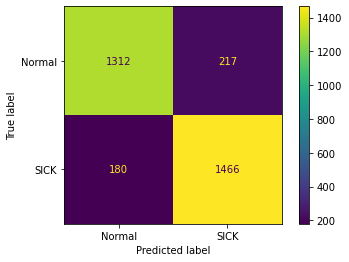

In [21]:
plot_confusion_matrix(RandomForestClassifier().fit(X_train, y_train), X_test, y_test, display_labels=le.classes_)

In [22]:
model = RandomForestClassifier().fit(X_train, y_train)

In [45]:
from shap import Explainer
import shap

In [46]:
explainer = Explainer(model)

In [59]:
shap_values = explainer(X_train[:1000])

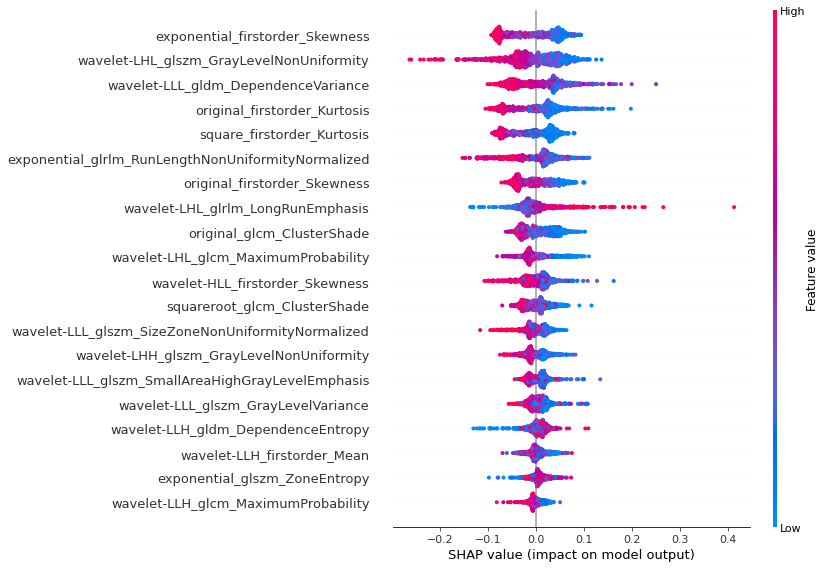

In [60]:
shap.summary_plot(shap_values.values[:,:,1], X_train[:1000])